In [1]:
import os

audio_files_datasets = r"C:\Users\datasets"
print("Dataset files:")
print(os.listdir(audio_files_datasets))


Dataset files:
['clean_testset_wav', 'clean_trainset_28spk_wav', 'clean_trainset_56spk_wav', 'noisy_testset_wav', 'noisy_trainset_28spk_wav', 'noisy_trainset_56spk_wav']


Loading test file: p232_001.wav
Sample rate: 48000 Hz
Clean audio shape: (83582,)


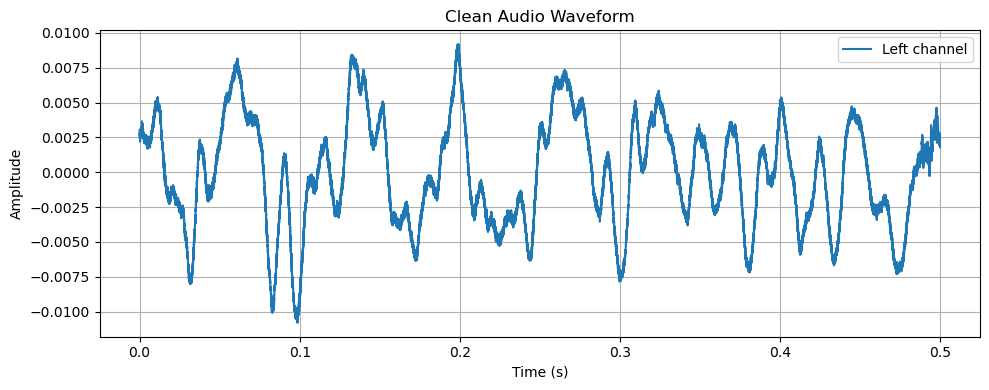

Noisy audio shape: (83582, 2)


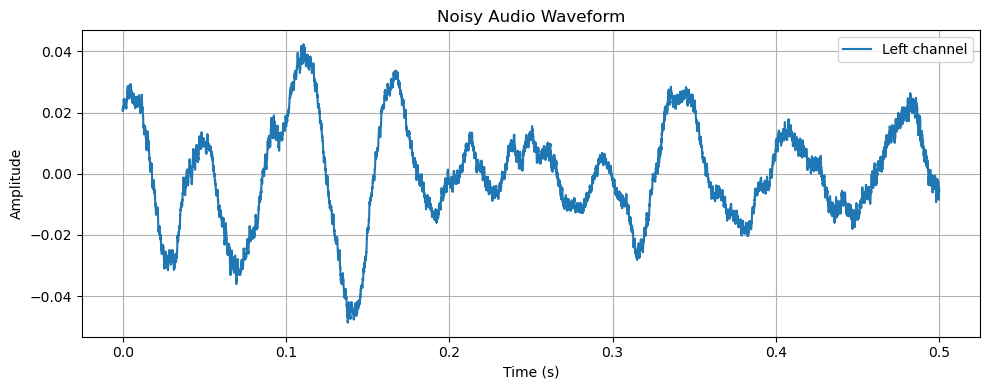

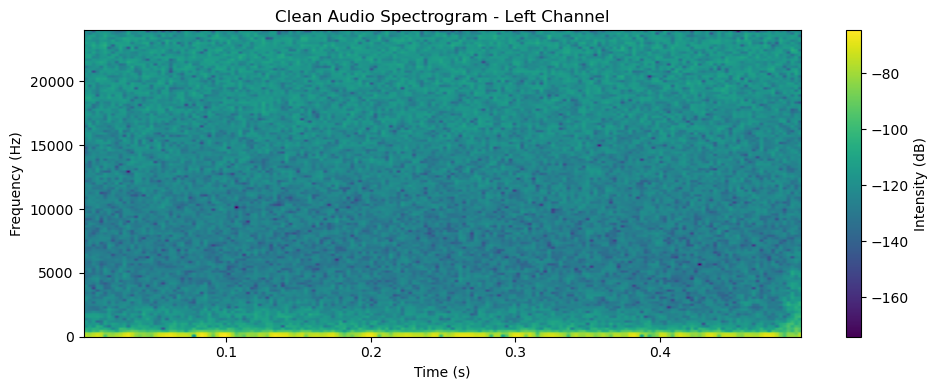

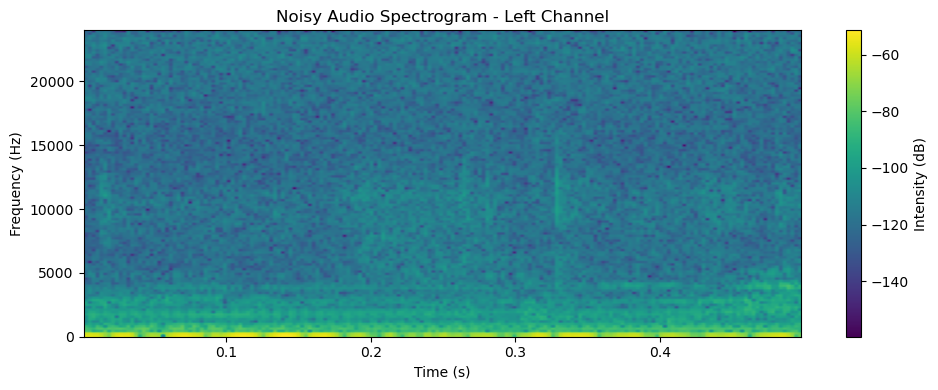

In [2]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

clean_test_data = os.path.join(audio_files_datasets, "clean_testset_wav")
noisy_test_data = os.path.join(audio_files_datasets, "noisy_testset_wav")


output_data = "visualization_results"
os.makedirs(output_data, exist_ok=True)


try:

    test_files = os.listdir(clean_test_data)
    test_file = test_files[0]

    print(f"Loading test file: {test_file}")


    clean_test_data_path = os.path.join(clean_test_data, test_file)
    clean_audio, sr = sf.read(clean_test_data_path)


    print(f"Sample rate: {sr} Hz")
    print(f"Clean audio shape: {clean_audio.shape}")


    if len(clean_audio.shape) == 1:
        clean_audio = np.stack([clean_audio, clean_audio], axis=1)


    max_len = min(int(0.5 * sr), clean_audio.shape[0])
    clean_audio_short = clean_audio[:max_len]


    time_axis = np.arange(max_len) / sr


    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, clean_audio_short[:, 0], label='Left channel')
    plt.title('Clean Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    noisy_data_path = os.path.join(noisy_test_data, test_file)
    noisy_audio, _ = sf.read(noisy_data_path)

    if len(noisy_audio.shape) == 1:
        noisy_audio = np.stack([noisy_audio, noisy_audio], axis=1)

    print(f"Noisy audio shape: {noisy_audio.shape}")


    noisy_audio_short = noisy_audio[:max_len]


    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, noisy_audio_short[:, 0], label='Left channel')
    plt.title('Noisy Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(10, 4))
    plt.specgram(clean_audio_short[:, 0], NFFT=256, Fs=sr, noverlap=128, cmap='viridis')
    plt.title('Clean Audio Spectrogram - Left Channel')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.colorbar(label='Intensity (dB)')
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(10, 4))
    plt.specgram(noisy_audio_short[:, 0], NFFT=256, Fs=sr, noverlap=128, cmap='viridis')
    plt.title('Noisy Audio Spectrogram - Left Channel')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.colorbar(label='Intensity (dB)')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")

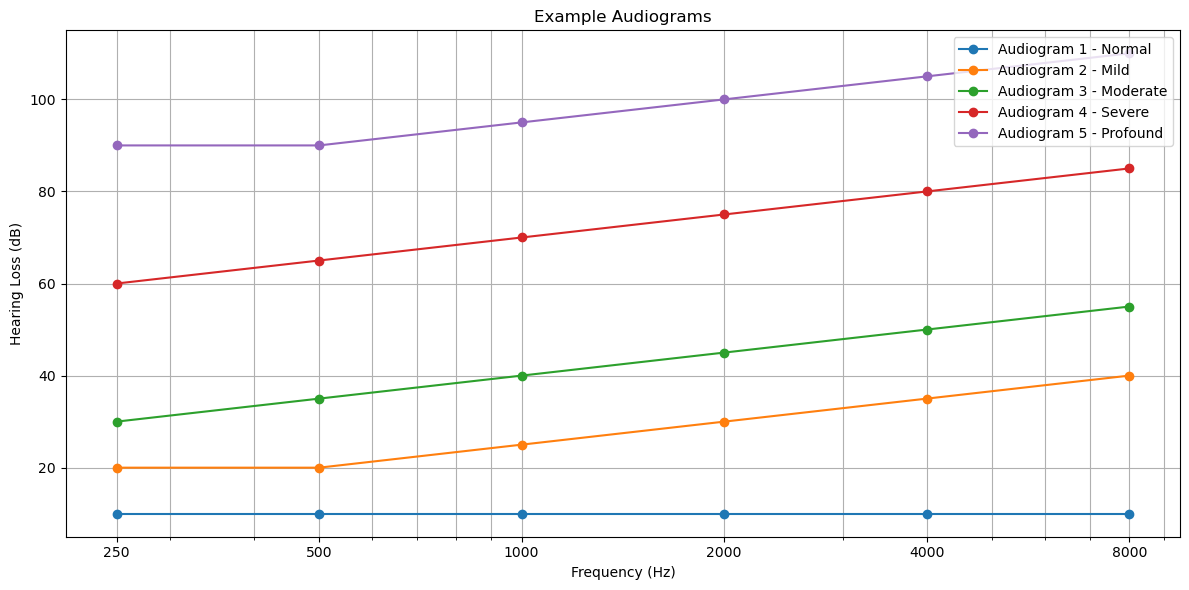

Loaded audio with shape (83582, 2) and sample rate 48000 Hz
Processing with Normal hearing loss...
Saved processed audio to hearing_loss_results\hearing_loss_Normal.wav
Processing with Mild hearing loss...
Saved processed audio to hearing_loss_results\hearing_loss_Mild.wav
Processing with Moderate hearing loss...
Saved processed audio to hearing_loss_results\hearing_loss_Moderate.wav
Processing with Severe hearing loss...
Saved processed audio to hearing_loss_results\hearing_loss_Severe.wav


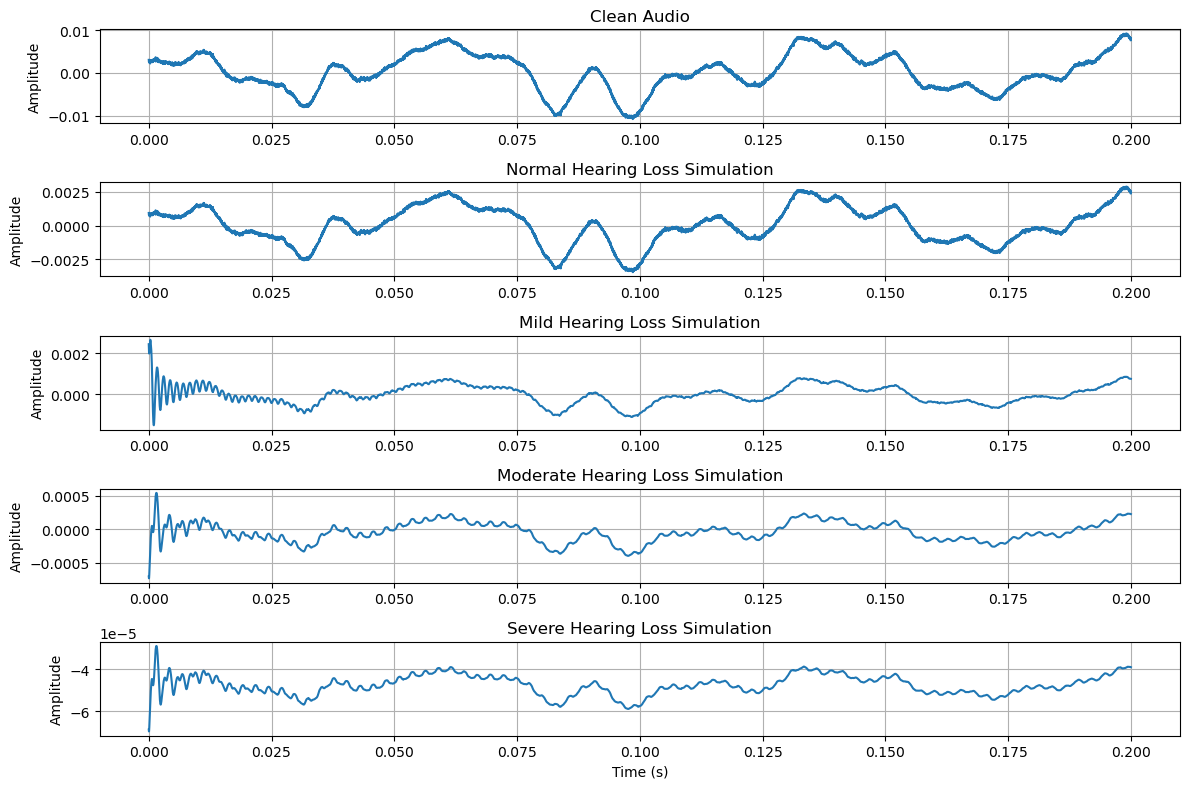

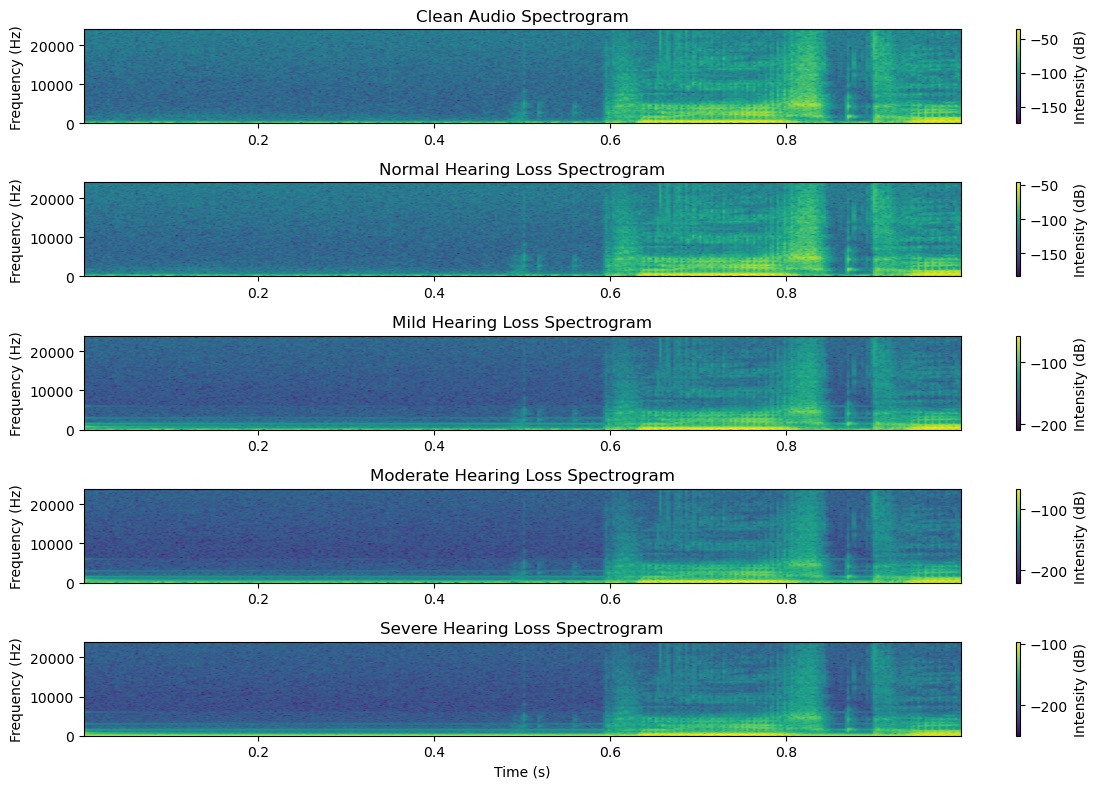

In [3]:
import torch
output_data = "hearing_loss_results"
os.makedirs(output_data, exist_ok=True)


class TestAudiogram:
    def __init__(self, name, hearing_loss_values):
        self.name = name
        self.values = hearing_loss_values

    def loss_at_frequency(self, freq):

        freqs = [250, 500, 1000, 2000, 4000, 8000]

        idx = min(range(len(freqs)), key=lambda i: abs(freqs[i]-freq))
        return self.values[idx]


audiograms = [
    TestAudiogram("Normal", [10, 10, 10, 10, 10, 10]),
    TestAudiogram("Mild", [20, 20, 25, 30, 35, 40]),
    TestAudiogram("Moderate", [30, 35, 40, 45, 50, 55]),
    TestAudiogram("Severe", [60, 65, 70, 75, 80, 85]),
    TestAudiogram("Profound", [90, 90, 95, 100, 105, 110])
]


plt.figure(figsize=(12, 6))
frequencies = [250, 500, 1000, 2000, 4000, 8000]

for i, audiogram in enumerate(audiograms):
    plt.plot(frequencies, audiogram.values, 'o-', label=f'Audiogram {i+1} - {audiogram.name}')

plt.title('Example Audiograms')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Hearing Loss (dB)')
plt.xscale('log')
plt.xticks(frequencies, [str(f) for f in frequencies])
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()


test_files = os.listdir(clean_test_data)
clean_test_data_path = os.path.join(clean_test_data, test_files[0])
clean_audio, sr = sf.read(clean_test_data_path)


if len(clean_audio.shape) == 1:
    clean_audio = np.stack([clean_audio, clean_audio], axis=1)

print(f"Loaded audio with shape {clean_audio.shape} and sample rate {sr} Hz")


max_len = min(int(1 * sr), clean_audio.shape[0])
clean_audio_short = clean_audio[:max_len]


def test_hearing_loss_simulation(audio, sr, audiogram):
    from scipy import signal


    output = np.zeros_like(audio)


    for ch in range(audio.shape[1]):

        n = len(audio[:, ch])
        audio_fft = np.fft.rfft(audio[:, ch])
        freq = np.fft.rfftfreq(n, d=1/sr)


        for i, f in enumerate(freq):
            if f > 0:

                attenuation_db = audiogram.loss_at_frequency(f)

                attenuation_linear = 10 ** (-attenuation_db / 20)
                audio_fft[i] *= attenuation_linear


        output[:, ch] = np.fft.irfft(audio_fft, n)

    return output


processed_outputs = []
descriptions = []

for audiogram in audiograms[:-1]:
    print(f"Processing with {audiogram.name} hearing loss...")

    try:

        output_audio = test_hearing_loss_simulation(clean_audio_short, sr, audiogram)


        output_path = os.path.join(output_data, f"hearing_loss_{audiogram.name}.wav")
        sf.write(output_path, output_audio, sr)

        processed_outputs.append(output_audio)
        descriptions.append(f"{audiogram.name} Hearing Loss")

        print(f"Saved processed audio to {output_path}")

    except Exception as e:
        print(f"Error in hearing loss processing: {e}")


plt.figure(figsize=(12, 8))


segment_duration = 0.2
segment_samples = int(segment_duration * sr)
segment_time = np.arange(segment_samples) / sr


plt.subplot(len(processed_outputs) + 1, 1, 1)
plt.plot(segment_time, clean_audio_short[:segment_samples, 0])
plt.title('Clean Audio')
plt.ylabel('Amplitude')
plt.grid(True)


for i, (processed, desc) in enumerate(zip(processed_outputs, descriptions)):
    plt.subplot(len(processed_outputs) + 1, 1, i + 2)
    plt.plot(segment_time, processed[:segment_samples, 0])
    plt.title(f'{desc} Simulation')
    plt.ylabel('Amplitude')
    plt.grid(True)

plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))


plt.subplot(len(processed_outputs) + 1, 1, 1)
plt.specgram(clean_audio_short[:, 0], NFFT=256, Fs=sr, noverlap=128, cmap='viridis')
plt.title('Clean Audio Spectrogram')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)')


for i, (processed, desc) in enumerate(zip(processed_outputs, descriptions)):
    plt.subplot(len(processed_outputs) + 1, 1, i + 2)
    plt.specgram(processed[:, 0], NFFT=256, Fs=sr, noverlap=128, cmap='viridis')
    plt.title(f'{desc} Spectrogram')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='Intensity (dB)')

plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

Loaded noisy audio with shape (83582, 2) and sample rate 48000 Hz

Model Architecture:
CNN_SpeechEnhancement_Model(
  (encoder): Sequential(
    (0): Conv1d(2, 64, kernel_size=(16,), stride=(8,), padding=(8,))
    (1): ReLU()
    (2): Conv1d(64, 128, kernel_size=(8,), stride=(4,), padding=(4,))
    (3): ReLU()
  )
  (middle): Sequential(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(128, 64, kernel_size=(8,), stride=(4,), padding=(2,))
    (1): ReLU()
    (2): ConvTranspose1d(64, 2, kernel_size=(16,), stride=(8,), padding=(4,))
  )
)

Total parameters: 233,986
Trainable parameters: 233,986

Layer Details:

encoder:
  0: Conv1d - Parameters: 2,112
  1: ReLU - Parameters: 0
  2: Conv1d - Parameters: 65,664
  3: ReLU - Parameters: 0

middle:
  0: Conv1d - Parameters: 49,280
  1: ReLU - Parameters: 0
  2: Conv1

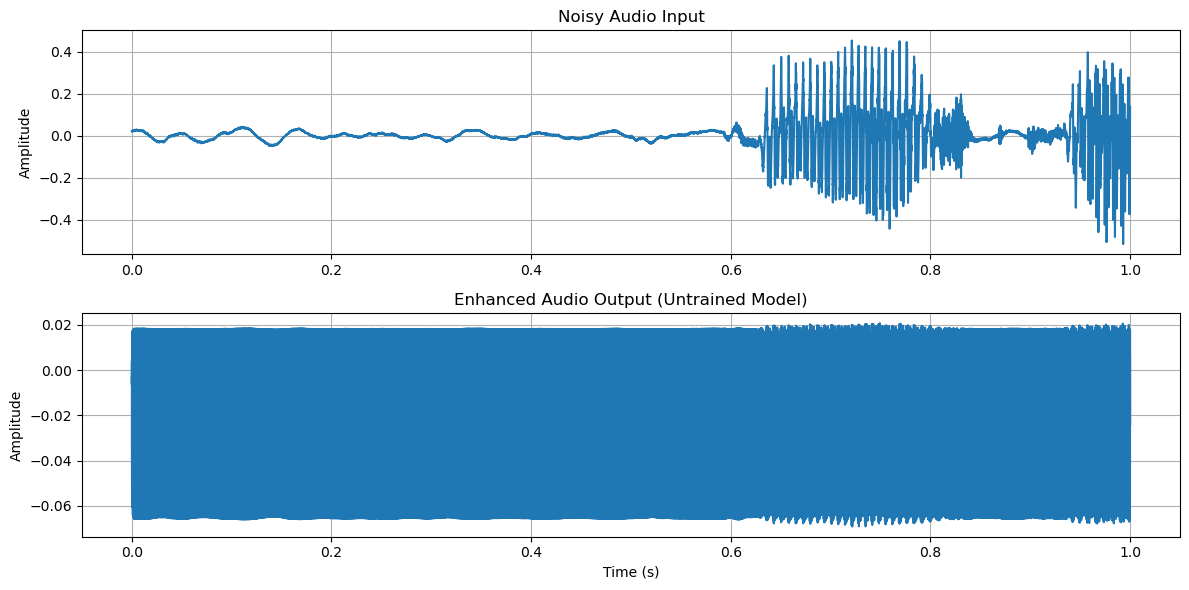

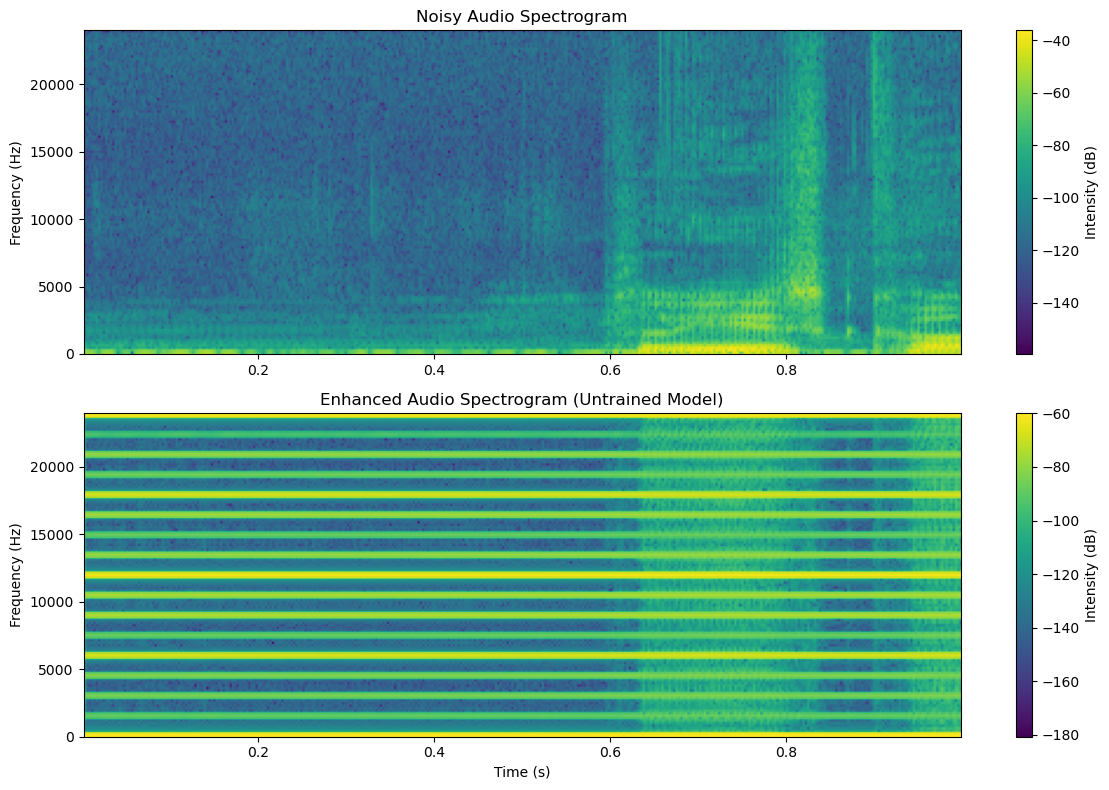

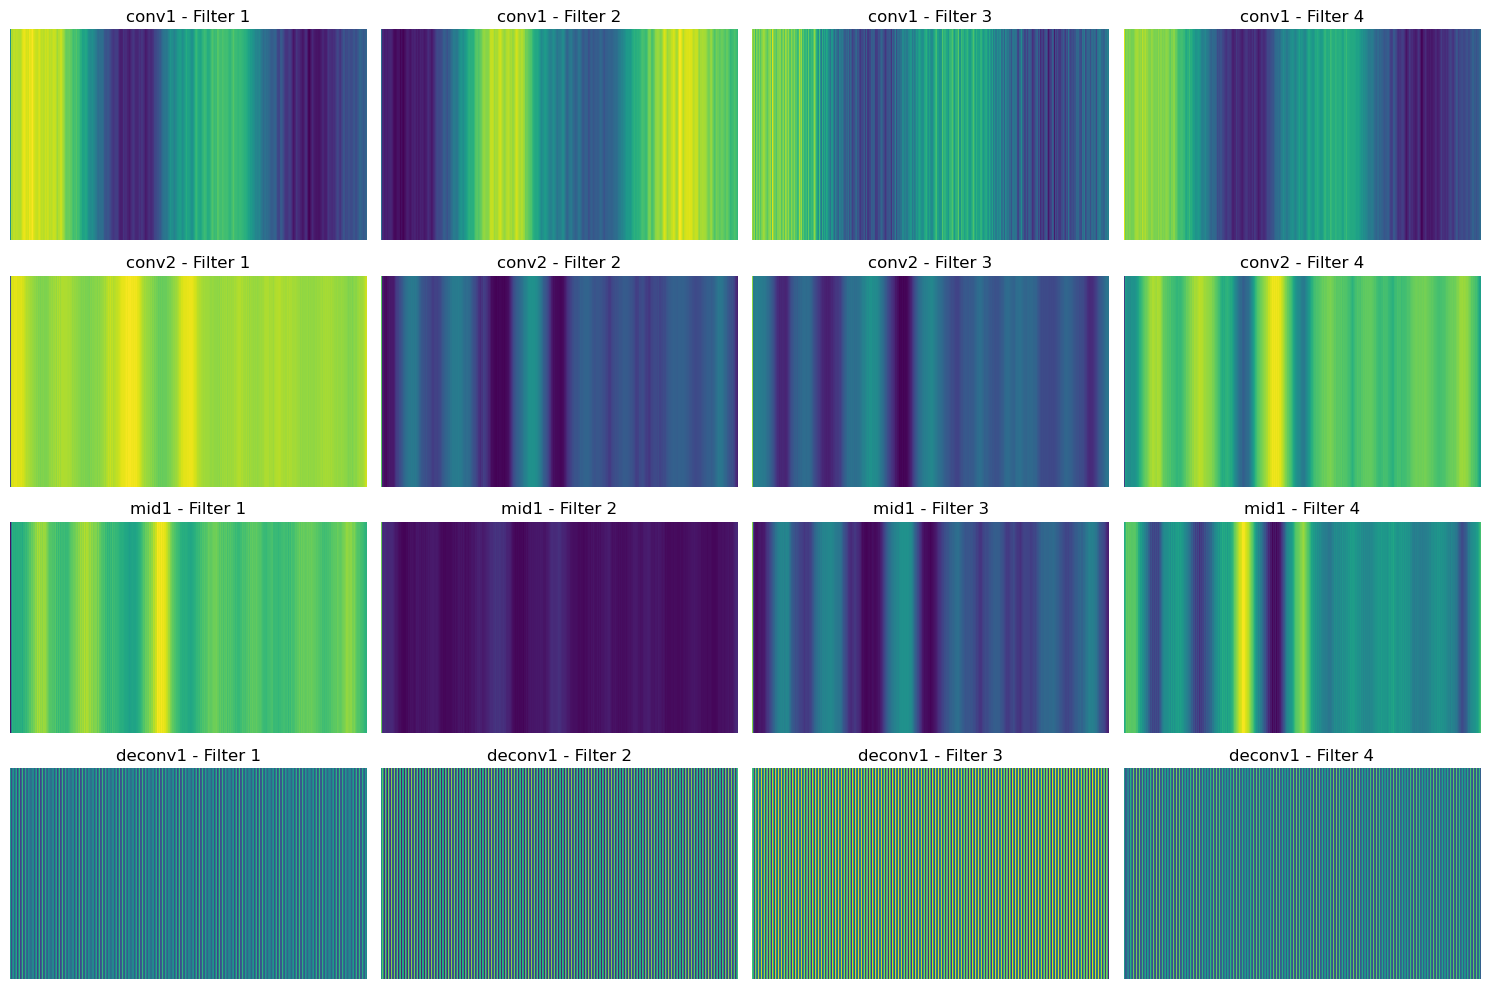

Model testing and visualization completed


In [4]:
import torch.nn as nn


output_data = "model_test_results"
os.makedirs(output_data, exist_ok=True)

class CNN_SpeechEnhancement_Model(nn.Module):
    
    def __init__(self, input_dim=2, hidden_dim=64):
        super().__init__()


        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=16, stride=8, padding=8),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim*2, kernel_size=8, stride=4, padding=4),
            nn.ReLU()
        )


        self.middle = nn.Sequential(
            nn.Conv1d(hidden_dim*2, hidden_dim*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim*2, hidden_dim*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(hidden_dim*2, hidden_dim, kernel_size=8, stride=4, padding=2),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_dim, input_dim, kernel_size=16, stride=8, padding=4),
        )

    def forward(self, x):
    

        original_length = x.shape[2]

        encoded = self.encoder(x)

        processed = self.middle(encoded)

        decoded = self.decoder(processed)


        if decoded.shape[2] != original_length:

            if decoded.shape[2] < original_length:
                decoded = nn.functional.pad(decoded, (0, original_length - decoded.shape[2]))
            else:
                decoded = decoded[:, :, :original_length]

        return decoded


def print_model_info(model):
   
    print("\nModel Architecture:")
    print(model)


    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")


    print("\nLayer Details:")
    for name, module in model.named_children():
        if isinstance(module, nn.Sequential):
            print(f"\n{name}:")
            for i, layer in enumerate(module):
                params = sum(p.numel() for p in layer.parameters())
                print(f"  {i}: {layer.__class__.__name__} - Parameters: {params:,}")
        else:
            params = sum(p.numel() for p in module.parameters())
            print(f"{name}: {module.__class__.__name__} - Parameters: {params:,}")


noisy_test_data = os.path.join(audio_files_datasets, "noisy_testset_wav")

test_files = os.listdir(noisy_test_data)
noisy_data_path = os.path.join(noisy_test_data, test_files[0])
noisy_audio, sr = sf.read(noisy_data_path)

if len(noisy_audio.shape) == 1:
    noisy_audio = np.stack([noisy_audio, noisy_audio], axis=1)

print(f"Loaded noisy audio with shape {noisy_audio.shape} and sample rate {sr} Hz")


max_len = min(int(1 * sr), noisy_audio.shape[0])
noisy_audio_short = noisy_audio[:max_len]


model = CNN_SpeechEnhancement_Model(input_dim=2, hidden_dim=64)


print_model_info(model)

model.eval()

noisy_tensor = torch.tensor(noisy_audio_short.T).unsqueeze(0).float()

print(f"\nInput tensor shape: {noisy_tensor.shape}")

with torch.no_grad():
    enhanced_tensor = model(noisy_tensor)

print(f"Output tensor shape: {enhanced_tensor.shape}")

enhanced_audio = enhanced_tensor.squeeze(0).permute(1, 0).numpy()

output_path = os.path.join(output_data, "enhanced_untrained.wav")
sf.write(output_path, enhanced_audio, sr)
print(f"Saved untrained model output to {output_path}")

plt.figure(figsize=(12, 6))

time_axis = np.arange(max_len) / sr

plt.subplot(2, 1, 1)
plt.plot(time_axis, noisy_audio_short[:, 0])
plt.title('Noisy Audio Input')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time_axis, enhanced_audio[:, 0])
plt.title('Enhanced Audio Output (Untrained Model)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(output_data, "enhancement_comparison_untrained.png"))
plt.show()

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.specgram(noisy_audio_short[:, 0], NFFT=256, Fs=sr, noverlap=128, cmap='viridis')
plt.title('Noisy Audio Spectrogram')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)')

plt.subplot(2, 1, 2)
plt.specgram(enhanced_audio[:, 0], NFFT=256, Fs=sr, noverlap=128, cmap='viridis')
plt.title('Enhanced Audio Spectrogram (Untrained Model)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)')

plt.tight_layout()
plt.savefig(os.path.join(output_data, "spectrogram_comparison_untrained.png"))
plt.show()

activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

hooks = []
hooks.append(model.encoder[0].register_forward_hook(get_activation('conv1')))
hooks.append(model.encoder[2].register_forward_hook(get_activation('conv2')))
hooks.append(model.middle[0].register_forward_hook(get_activation('mid1')))
hooks.append(model.decoder[0].register_forward_hook(get_activation('deconv1')))

with torch.no_grad():
    model(noisy_tensor)

for hook in hooks:
    hook.remove()

plt.figure(figsize=(15, 10))

layers = ['conv1', 'conv2', 'mid1', 'deconv1']
num_filters_to_plot = 4

for i, layer_name in enumerate(layers):
    activation = activations[layer_name].squeeze(0).cpu().numpy()
    num_filters = min(num_filters_to_plot, activation.shape[0])

    for j in range(num_filters):
        plt.subplot(len(layers), num_filters_to_plot, i*num_filters_to_plot + j + 1)


        act_slice = activation[j][:500]


        plt.imshow(act_slice.reshape(1, -1), aspect='auto', cmap='viridis')
        plt.title(f'{layer_name} - Filter {j+1}')
        plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(output_data, "feature_maps.png"))
plt.show()

print("Model testing and visualization completed")

Loaded audio files with sample rate 48000 Hz

Testing simplified intelligibility metric...
Intelligibility score (clean vs. noisy): 0.9911
Score at 30 dB SNR: 0.9998
Score at 20 dB SNR: 0.9975
Score at 10 dB SNR: 0.9767
Score at 5 dB SNR: 0.9358
Score at 0 dB SNR: 0.8532
Score at -5 dB SNR: 0.7438


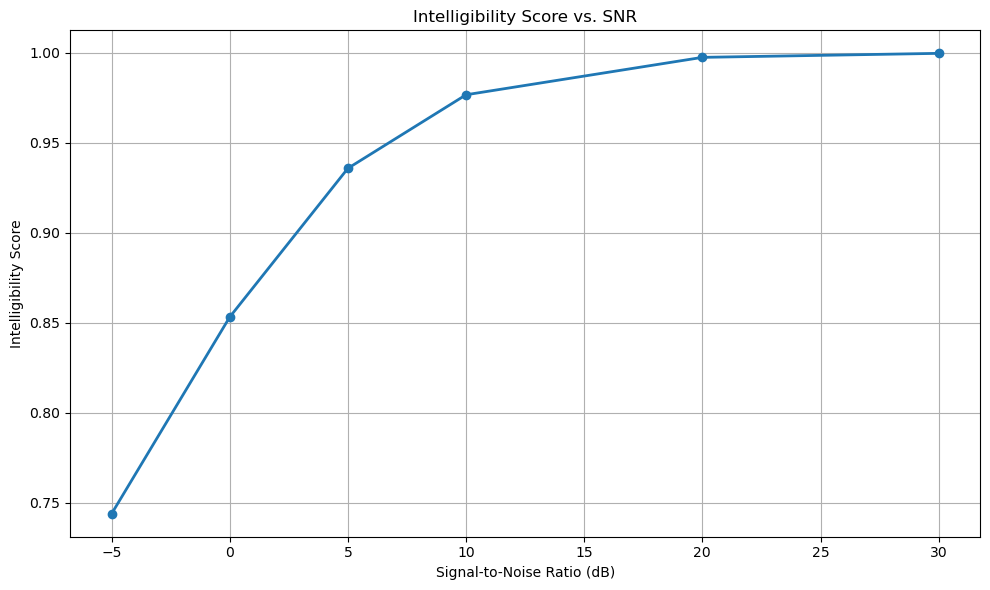


Testing hearing intelligibility loss function...
Severity 0.0: Loss = -0.9911, Score = 0.9911
Severity 0.2: Loss = -0.9910, Score = 0.9910
Severity 0.4: Loss = -0.9909, Score = 0.9909
Severity 0.6: Loss = -0.9908, Score = 0.9908
Severity 0.8: Loss = -0.9907, Score = 0.9907


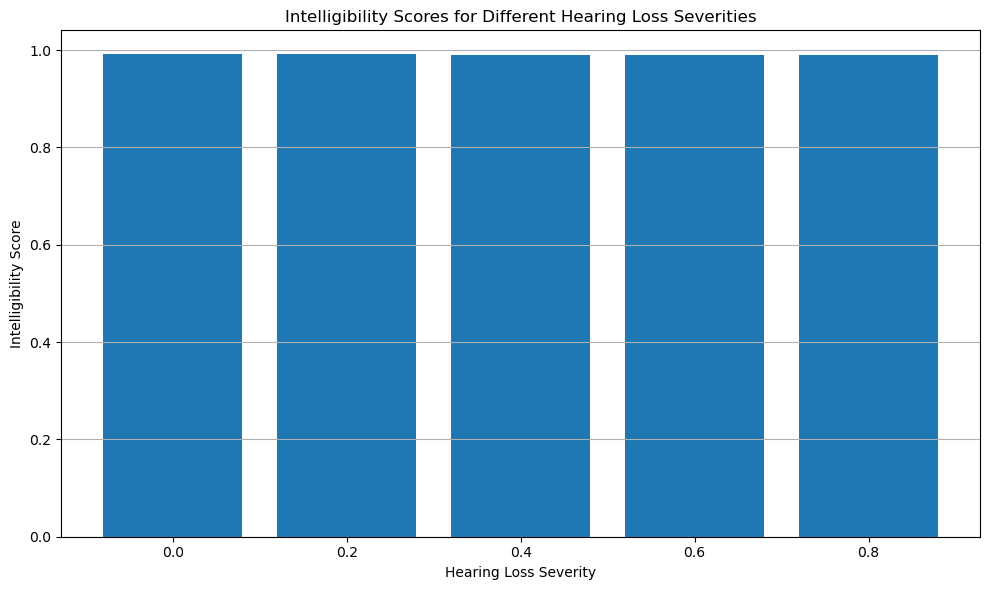

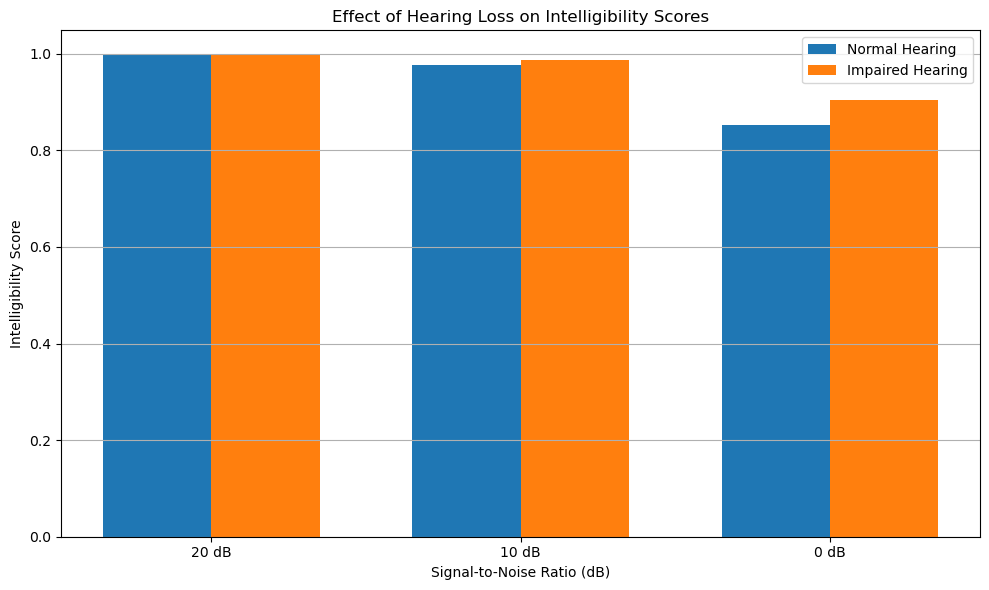

Loss function testing and visualization completed


In [5]:
output_data = "loss_function_results"
os.makedirs(output_data, exist_ok=True)


class SimplifiedMBSTOI:
   
    def __init__(self):
        pass

    def __call__(self, clean_left, clean_right, processed_left, processed_right):
        

        corr_left = self._correlation(clean_left, processed_left)
        corr_right = self._correlation(clean_right, processed_right)

        score = (corr_left + corr_right) / 2

        return torch.tensor(score)

    def _correlation(self, x, y):

        x = x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x
        y = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else y


        min_len = min(len(x), len(y))
        x = x[:min_len]
        y = y[:min_len]


        x_centered = x - np.mean(x)
        y_centered = y - np.mean(y)

        numerator = np.sum(x_centered * y_centered)
        denominator = np.sqrt(np.sum(x_centered**2) * np.sum(y_centered**2))


        if denominator == 0:
            return 0

        corr = numerator / denominator


        return (corr + 1) / 2


def simulate_hearing_loss(audio, severity=0.5):


    n_samples = audio.shape[1]


    output = audio.clone()


    for ch in range(audio.shape[0]):

        audio_fft = torch.fft.rfft(audio[ch])

        freq_bins = audio_fft.shape[0]
        attenuation = torch.linspace(1, 1 - severity, freq_bins)

        audio_fft = audio_fft * attenuation

        output[ch] = torch.fft.irfft(audio_fft, n_samples)

    return output

class Test_Intelligibility_Loss(nn.Module):

    def __init__(self):
        super().__init__()
        self.mbstoi = SimplifiedMBSTOI()

    def forward(self, enhanced, targets, hearing_loss_severity=0.5):

        batch_size = enhanced.shape[0]
        scores = []

        for i in range(batch_size):

            enhanced_sample = enhanced[i]
            target_sample = targets[i]

            enhanced_with_loss = simulate_hearing_loss(enhanced_sample, hearing_loss_severity)

            score = self.mbstoi(
                target_sample[0], target_sample[1],
                enhanced_with_loss[0], enhanced_with_loss[1]
            )
            scores.append(score)

        return -torch.stack(scores)


test_files = os.listdir(clean_test_data)
test_file = test_files[0]

clean_test_data_path = os.path.join(clean_test_data, test_file)
noisy_data_path = os.path.join(noisy_test_data, test_file)

clean_audio, sr = sf.read(clean_test_data_path)
noisy_audio, _ = sf.read(noisy_data_path)


if len(clean_audio.shape) == 1:
    clean_audio = np.stack([clean_audio, clean_audio], axis=1)
if len(noisy_audio.shape) == 1:
    noisy_audio = np.stack([noisy_audio, noisy_audio], axis=1)

print(f"Loaded audio files with sample rate {sr} Hz")

def test_intelligibility_metric():

    print("\nTesting simplified intelligibility metric...")

    mbstoi = SimplifiedMBSTOI()

    max_len = min(int(1 * sr), clean_audio.shape[0], noisy_audio.shape[0])
    clean_short = clean_audio[:max_len]
    noisy_short = noisy_audio[:max_len]

    clean_tensor = torch.tensor(clean_short.T)
    noisy_tensor = torch.tensor(noisy_short.T)


    score = mbstoi(
        clean_tensor[0], clean_tensor[1],
        noisy_tensor[0], noisy_tensor[1]
    )

    print(f"Intelligibility score (clean vs. noisy): {score.item():.4f}")


    snr_levels = [30, 20, 10, 5, 0, -5]
    scores = []

    for snr in snr_levels:

        clean_power = np.mean(clean_short**2)
        noise = np.random.normal(0, 1, clean_short.shape)
        noise_power = np.mean(noise**2)
        noise_factor = np.sqrt(clean_power / (noise_power * 10**(snr/10)))

        synthetic_noisy = clean_short + noise_factor * noise
        synthetic_noisy_tensor = torch.tensor(synthetic_noisy.T)


        score = mbstoi(
            clean_tensor[0], clean_tensor[1],
            synthetic_noisy_tensor[0], synthetic_noisy_tensor[1]
        )

        scores.append(score.item())
        print(f"Score at {snr} dB SNR: {score.item():.4f}")


    plt.figure(figsize=(10, 6))
    plt.plot(snr_levels, scores, 'o-', linewidth=2)
    plt.title('Intelligibility Score vs. SNR')
    plt.xlabel('Signal-to-Noise Ratio (dB)')
    plt.ylabel('Intelligibility Score')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_data, "intelligibility_vs_snr.png"))
    plt.show()

    return scores


def test_hearing_loss_intelligibility():

    print("\nTesting hearing intelligibility loss function...")


    max_len = min(int(1 * sr), clean_audio.shape[0], noisy_audio.shape[0])
    clean_short = clean_audio[:max_len]
    noisy_short = noisy_audio[:max_len]


    clean_tensor = torch.tensor(clean_short.T).unsqueeze(0)
    noisy_tensor = torch.tensor(noisy_short.T).unsqueeze(0)


    loss_fn = Test_Intelligibility_Loss()


    severities = [0.0, 0.2, 0.4, 0.6, 0.8]
    losses = []
    scores = []

    for severity in severities:

        with torch.no_grad():
            loss = loss_fn(noisy_tensor, clean_tensor, severity)


        score = -loss.item()

        losses.append(loss.item())
        scores.append(score)

        print(f"Severity {severity:.1f}: Loss = {loss.item():.4f}, Score = {score:.4f}")


    plt.figure(figsize=(10, 6))
    plt.bar(range(len(severities)), scores)
    plt.xticks(range(len(severities)), [f"{s:.1f}" for s in severities])
    plt.title('Intelligibility Scores for Different Hearing Loss Severities')
    plt.xlabel('Hearing Loss Severity')
    plt.ylabel('Intelligibility Score')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(output_data, "scores_by_severity.png"))
    plt.show()


    snr_levels = [20, 10, 0]
    normal_scores = []
    impaired_scores = []

    for snr in snr_levels:

        clean_power = np.mean(clean_short**2)
        noise = np.random.normal(0, 1, clean_short.shape)
        noise_power = np.mean(noise**2)
        noise_factor = np.sqrt(clean_power / (noise_power * 10**(snr/10)))

        synthetic_noisy = clean_short + noise_factor * noise
        noisy_tensor = torch.tensor(synthetic_noisy.T).unsqueeze(0)


        with torch.no_grad():
            loss = loss_fn(noisy_tensor, clean_tensor, 0.0)
        normal_score = -loss.item()
        normal_scores.append(normal_score)


        with torch.no_grad():
            loss = loss_fn(noisy_tensor, clean_tensor, 0.6)
        impaired_score = -loss.item()
        impaired_scores.append(impaired_score)


    plt.figure(figsize=(10, 6))
    x = np.arange(len(snr_levels))
    width = 0.35

    plt.bar(x - width/2, normal_scores, width, label='Normal Hearing')
    plt.bar(x + width/2, impaired_scores, width, label='Impaired Hearing')

    plt.title('Effect of Hearing Loss on Intelligibility Scores')
    plt.xlabel('Signal-to-Noise Ratio (dB)')
    plt.ylabel('Intelligibility Score')
    plt.xticks(x, [f'{snr} dB' for snr in snr_levels])
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(output_data, "normal_vs_impaired_scores.png"))
    plt.show()


test_intelligibility_metric()
test_hearing_loss_intelligibility()

print("Loss function testing and visualization completed")

Starting minimal training demonstration...
Created model with 47,298 parameters


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 0/20, Loss: 18.082539
Batch 5/20, Loss: 6.347235
Batch 10/20, Loss: 1.847734
Batch 15/20, Loss: 1.265705


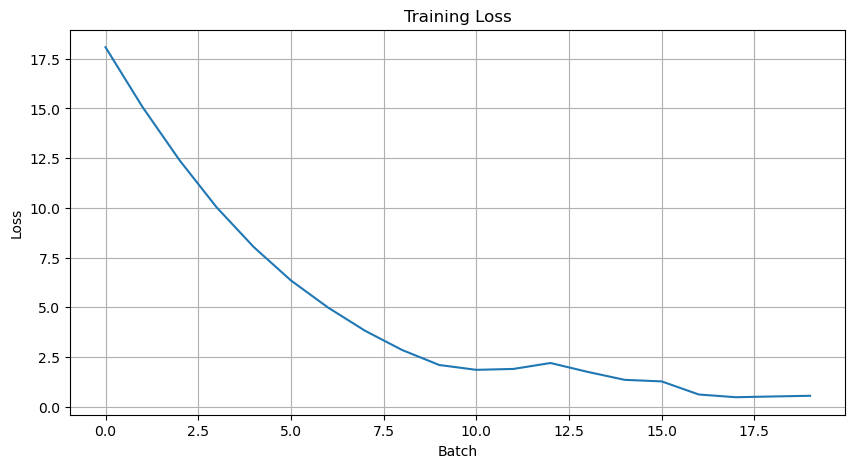


Evaluating model on test sample...


C:\Users\rucha\AppData\Local\Temp\ipykernel_21080\2350825159.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clean_tensor = torch.tensor(clean_audio.T).unsqueeze(0).float()
C:\Users\rucha\AppData\Local\Temp\ipykernel_21080\2350825159.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_tensor = torch.tensor(noisy_audio.T).unsqueeze(0).float()


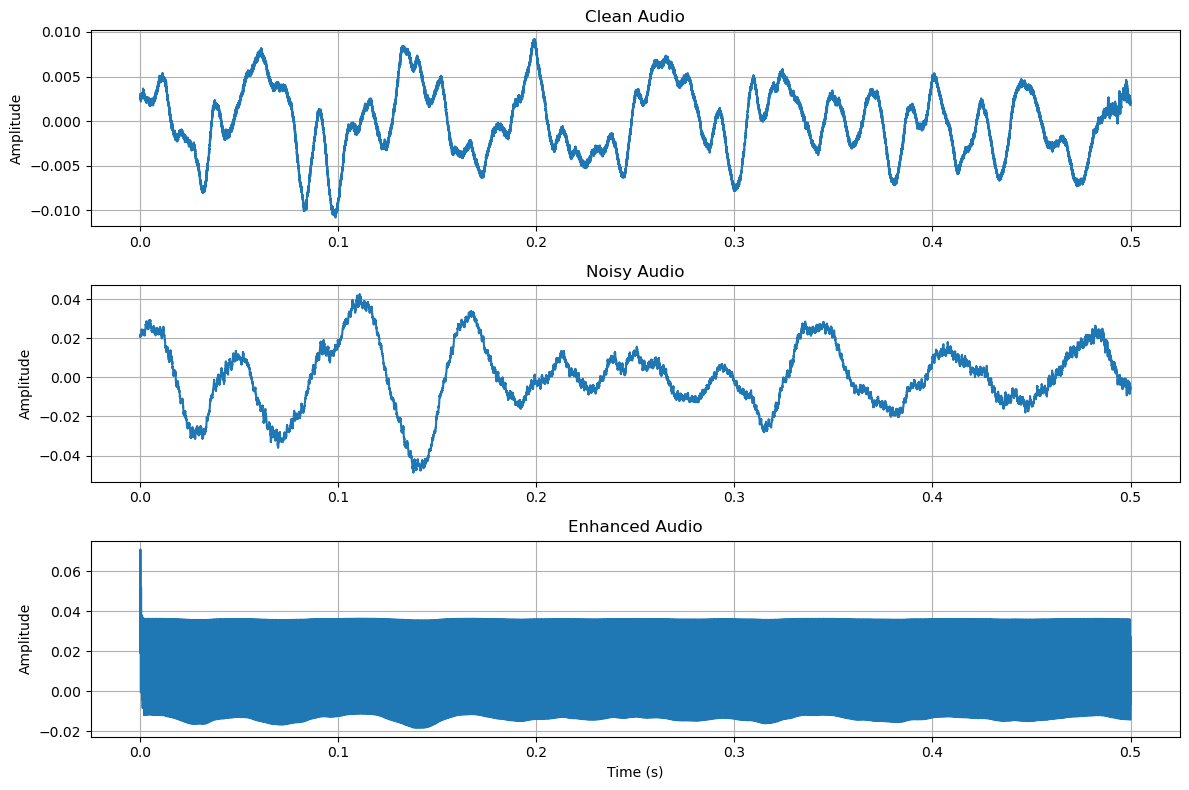

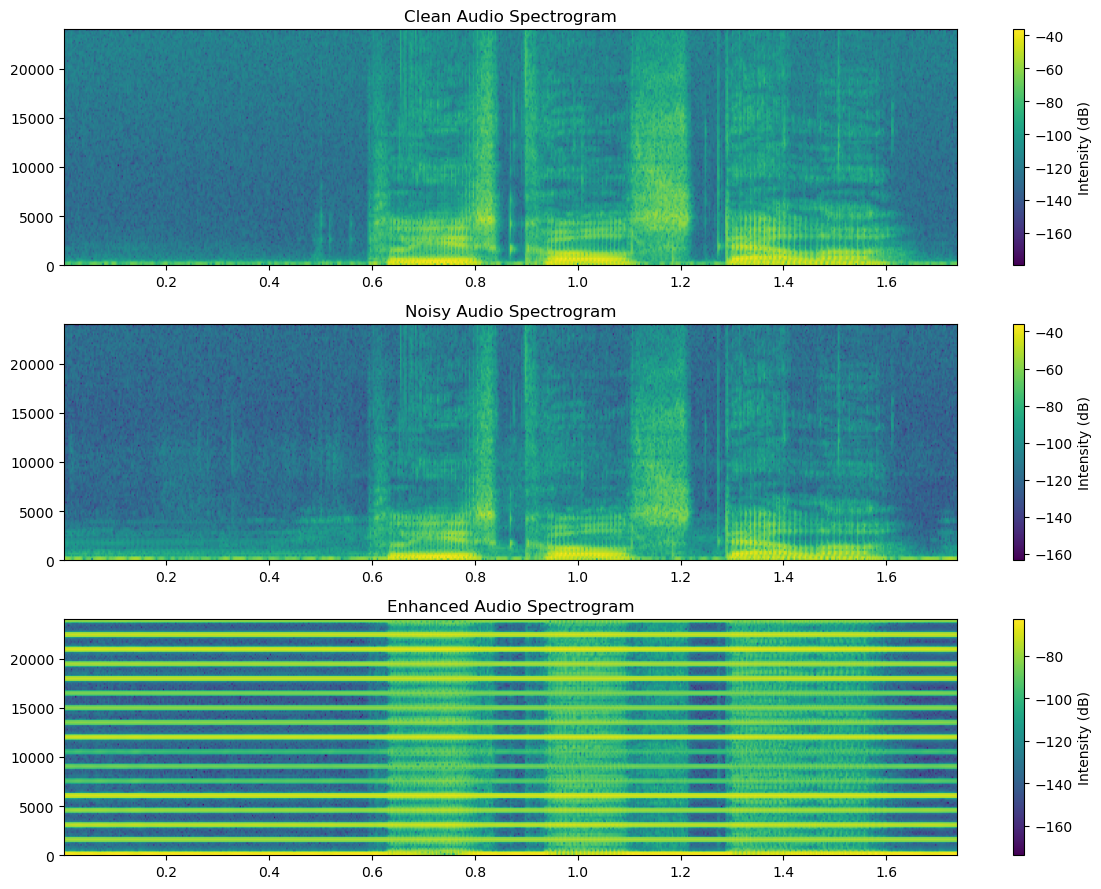

Model saved to training_results\trained_model.pt
Training demonstration completed!


In [6]:

import torch.optim as optim
import random
from tqdm.notebook import tqdm


output_data = "training_results"
os.makedirs(output_data, exist_ok=True)


clean_train_data = os.path.join(audio_files_datasets, "clean_trainset_28spk_wav")
noisy_train_data = os.path.join(audio_files_datasets, "noisy_trainset_28spk_wav")


def load_audio_file(filepath, max_len=None):
    audio, sr = sf.read(filepath)


    if len(audio.shape) == 1:
        audio = np.stack([audio, audio], axis=1)


    if max_len is not None and audio.shape[0] > max_len:
        audio = audio[:max_len]

    return torch.tensor(audio), sr


def get_batch(clean_data, noisy_data , batch_size=1, max_len=16000):

    clean_files = os.listdir(clean_data)


    batch_files = random.sample(clean_files, batch_size)

    clean_batch = []
    noisy_batch = []

    for file in batch_files:
        clean_test_data_path = os.path.join(clean_data, file)
        noisy_data_path = os.path.join(noisy_data , file)

        try:
            clean_audio, _ = load_audio_file(clean_test_data_path, max_len)
            noisy_audio, _ = load_audio_file(noisy_data_path, max_len)


            min_len = min(clean_audio.shape[0], noisy_audio.shape[0])
            clean_audio = clean_audio[:min_len]
            noisy_audio = noisy_audio[:min_len]

            clean_batch.append(clean_audio)
            noisy_batch.append(noisy_audio)
        except Exception as e:
            print(f"Error loading file {file}: {e}")
            continue


    if len(clean_batch) == 0:
        return get_batch(clean_data, noisy_data , batch_size, max_len)


    clean_batch = torch.stack(clean_batch)
    noisy_batch = torch.stack(noisy_batch)

    return clean_batch, noisy_batch


class CNN_SpeechEnhancement_Model(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64):
        super().__init__()


        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=16, stride=8, padding=8),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim*2, kernel_size=8, stride=4, padding=4),
            nn.ReLU()
        )

        self.middle = nn.Sequential(
            nn.Conv1d(hidden_dim*2, hidden_dim*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(hidden_dim*2, hidden_dim, kernel_size=8, stride=4, padding=2),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_dim, input_dim, kernel_size=16, stride=8, padding=4)
        )

    def forward(self, x):
        original_length = x.shape[2]
        encoded = self.encoder(x)
        processed = self.middle(encoded)
        decoded = self.decoder(processed)


        if decoded.shape[2] != original_length:
            if decoded.shape[2] < original_length:
                decoded = nn.functional.pad(decoded, (0, original_length - decoded.shape[2]))
            else:
                decoded = decoded[:, :, :original_length]

        return decoded


class Test_Intelligibility_Loss(nn.Module):
    def __init__(self):
        super().__init__()

        self.mse = nn.MSELoss()

    def forward(self, enhanced, targets, hearing_loss_severity=0.5):

        mse_loss = self.mse(enhanced, targets)


        batch_size = enhanced.shape[0]
        penalty = 0


        for i in range(batch_size):
            enh = enhanced[i]
            tgt = targets[i]


            enh_fft = torch.abs(torch.fft.rfft(enh, dim=1))
            tgt_fft = torch.abs(torch.fft.rfft(tgt, dim=1))


            freq_bins = enh_fft.shape[1]
            weights = torch.linspace(1, 1 + hearing_loss_severity, freq_bins)


            weighted_diff = torch.mean((enh_fft - tgt_fft)**2 * weights)

            penalty += weighted_diff

        penalty = penalty / batch_size


        total_loss = mse_loss + 0.1 * penalty

        return total_loss


def train_one_batch(model, optimizer, loss_fn, clean_batch, noisy_batch, hearing_loss_severity=0.5):

    clean_input = clean_batch.permute(0, 2, 1).float()
    noisy_input = noisy_batch.permute(0, 2, 1).float()


    enhanced = model(noisy_input)


    loss = loss_fn(enhanced, clean_input, hearing_loss_severity)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item(), enhanced


def plot_loss_history(loss_history):
    """Plot the loss history"""
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.title('Training Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig(os.path.join(output_data, "loss_history.png"))
    plt.show()


def evaluate_model(model, clean_audio, noisy_audio, sr):

    clean_tensor = torch.tensor(clean_audio.T).unsqueeze(0).float()
    noisy_tensor = torch.tensor(noisy_audio.T).unsqueeze(0).float()


    with torch.no_grad():
        enhanced_tensor = model(noisy_tensor)


    enhanced_audio = enhanced_tensor.squeeze(0).permute(1, 0).numpy()


    sf.write(os.path.join(output_data, "test_clean.wav"), clean_audio, sr)
    sf.write(os.path.join(output_data, "test_noisy.wav"), noisy_audio, sr)
    sf.write(os.path.join(output_data, "test_enhanced.wav"), enhanced_audio, sr)


    plt.figure(figsize=(12, 8))


    segment_duration = 0.5
    segment_samples = int(segment_duration * sr)
    time_axis = np.arange(segment_samples) / sr

    plt.subplot(3, 1, 1)
    plt.plot(time_axis, clean_audio[:segment_samples, 0])
    plt.title('Clean Audio')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(time_axis, noisy_audio[:segment_samples, 0])
    plt.title('Noisy Audio')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(time_axis, enhanced_audio[:segment_samples, 0])
    plt.title('Enhanced Audio')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(output_data, "waveform_comparison.png"))
    plt.show()


    plt.figure(figsize=(12, 9))

    plt.subplot(3, 1, 1)
    plt.specgram(clean_audio[:, 0], NFFT=256, Fs=sr, noverlap=128, cmap='viridis')
    plt.title('Clean Audio Spectrogram')
    plt.colorbar(label='Intensity (dB)')

    plt.subplot(3, 1, 2)
    plt.specgram(noisy_audio[:, 0], NFFT=256, Fs=sr, noverlap=128, cmap='viridis')
    plt.title('Noisy Audio Spectrogram')
    plt.colorbar(label='Intensity (dB)')

    plt.subplot(3, 1, 3)
    plt.specgram(enhanced_audio[:, 0], NFFT=256, Fs=sr, noverlap=128, cmap='viridis')
    plt.title('Enhanced Audio Spectrogram')
    plt.colorbar(label='Intensity (dB)')

    plt.tight_layout()
    plt.savefig(os.path.join(output_data, "spectrogram_comparison.png"))
    plt.show()

    return enhanced_audio


def train_minimal():

    print("Starting minimal training demonstration...")


    model = CNN_SpeechEnhancement_Model(input_dim=2, hidden_dim=32)
    print(f"Created model with {sum(p.numel() for p in model.parameters()):,} parameters")


    loss_fn = Test_Intelligibility_Loss()


    optimizer = optim.Adam(model.parameters(), lr=0.001)


    num_batches = 20
    batch_size = 2
    max_len = 16000


    loss_history = []

    for batch_idx in tqdm(range(num_batches), desc="Training"):

        clean_batch, noisy_batch = get_batch(clean_train_data, noisy_train_data, batch_size, max_len)


        loss, _ = train_one_batch(model, optimizer, loss_fn, clean_batch, noisy_batch)


        loss_history.append(loss)


        if batch_idx % 5 == 0:
            print(f"Batch {batch_idx}/{num_batches}, Loss: {loss:.6f}")


    plot_loss_history(loss_history)


    test_files = os.listdir(clean_test_data)
    clean_test_data_path = os.path.join(clean_test_data, test_files[0])
    noisy_data_path = os.path.join(noisy_test_data, test_files[0])

    clean_audio, sr = load_audio_file(clean_test_data_path)
    noisy_audio, _ = load_audio_file(noisy_data_path)


    min_len = min(clean_audio.shape[0], noisy_audio.shape[0])
    clean_audio = clean_audio[:min_len]
    noisy_audio = noisy_audio[:min_len]


    print("\nEvaluating model on test sample...")
    enhanced_audio = evaluate_model(model, clean_audio, noisy_audio, sr)


    torch.save(model.state_dict(), os.path.join(output_data, "trained_model.pt"))
    print(f"Model saved to {os.path.join(output_data, 'trained_model.pt')}")

    print("Training demonstration completed!")
    return model


model = train_minimal()

Testing trained speech enhancement model...
Loaded trained model successfully!

Evaluating model on test files...
Processing file 1/3: p232_001.wav
  Normal hearing - Noisy: 0.8242, Enhanced: 0.5157
  With hearing loss - Noisy: 0.8231, Enhanced: 0.5239
Processing file 2/3: p232_002.wav
  Normal hearing - Noisy: 0.8971, Enhanced: 0.5232
  With hearing loss - Noisy: 0.8937, Enhanced: 0.5355
Processing file 3/3: p232_003.wav
  Normal hearing - Noisy: 0.8123, Enhanced: 0.5131
  With hearing loss - Noisy: 0.8080, Enhanced: 0.5200

Average scores:
Normal hearing - Noisy: 0.8445, Enhanced: 0.5174
With hearing loss - Noisy: 0.8416, Enhanced: 0.5265
No improvement for normal hearing: -0.3272
No improvement for hearing loss: -0.3151


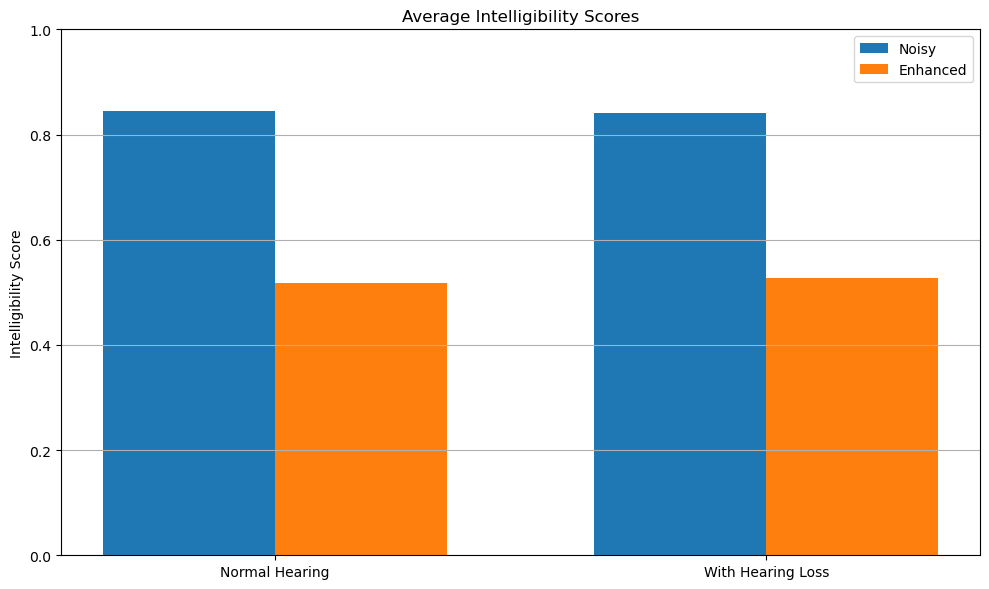

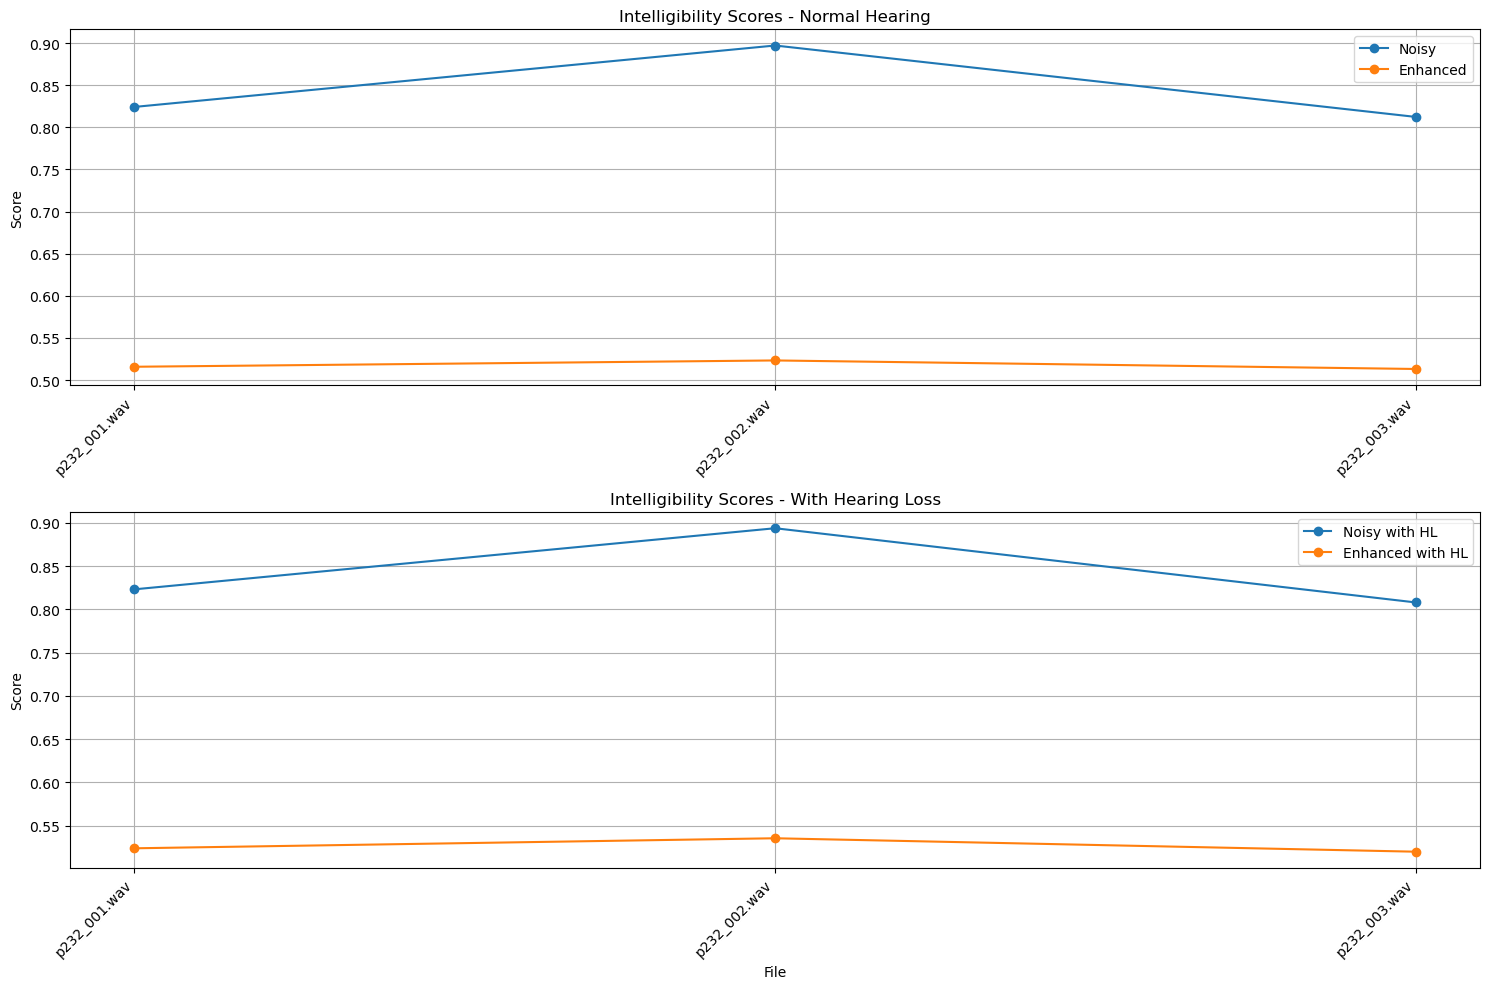


Evaluation completed!


In [7]:
from pathlib import Path


output_data = "final_evaluation_results"
os.makedirs(output_data, exist_ok=True)




model_path = os.path.join("training_results", "trained_model.pt")


class CNN_SpeechEnhancement_Model(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=16, stride=8, padding=8),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim*2, kernel_size=8, stride=4, padding=4),
            nn.ReLU()
        )

        self.middle = nn.Sequential(
            nn.Conv1d(hidden_dim*2, hidden_dim*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(hidden_dim*2, hidden_dim, kernel_size=8, stride=4, padding=2),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_dim, input_dim, kernel_size=16, stride=8, padding=4)
        )

    def forward(self, x):
        original_length = x.shape[2]
        encoded = self.encoder(x)
        processed = self.middle(encoded)
        decoded = self.decoder(processed)

        if decoded.shape[2] != original_length:
            if decoded.shape[2] < original_length:
                decoded = nn.functional.pad(decoded, (0, original_length - decoded.shape[2]))
            else:
                decoded = decoded[:, :, :original_length]

        return decoded


def simulate_hearing_loss(audio, severity=0.5):
    from scipy import signal


    output = np.zeros_like(audio)


    for ch in range(audio.shape[1]):

        n = len(audio[:, ch])
        audio_fft = np.fft.rfft(audio[:, ch])
        freq = np.fft.rfftfreq(n, d=1/48000)

        for i, f in enumerate(freq):
            if f > 0:

                attenuation = severity * (f / 20000)
                audio_fft[i] *= max(0, 1 - attenuation)


        output[:, ch] = np.fft.irfft(audio_fft, n)

    return output


def simple_intelligibility(clean, processed):

    window_size = 512
    hop_size = 256
    corrs = []

    for start in range(0, len(clean) - window_size, hop_size):
        clean_window = clean[start:start+window_size, 0]
        proc_window = processed[start:start+window_size, 0]


        clean_window = clean_window - np.mean(clean_window)
        proc_window = proc_window - np.mean(proc_window)


        numerator = np.sum(clean_window * proc_window)
        denominator = np.sqrt(np.sum(clean_window**2) * np.sum(proc_window**2))

        if denominator > 0:
            corr = numerator / denominator
            corrs.append((corr + 1) / 2)


    return np.mean(corrs) if corrs else 0


def load_audio_file(filepath, max_len=None):
    audio, sr = sf.read(filepath)


    if len(audio.shape) == 1:
        audio = np.stack([audio, audio], axis=1)


    if max_len is not None and audio.shape[0] > max_len:
        audio = audio[:max_len]

    return audio, sr


def model_evaluation_test_set(model, num_files=5, max_len=None):

    test_files = os.listdir(clean_test_data)
    if num_files > len(test_files):
        num_files = len(test_files)

    test_files = test_files[:num_files]


    results = {
        'files': [],
        'noisy_scores': [],
        'enhanced_scores': [],
        'noisy_hl_scores': [],
        'enhanced_hl_scores': []
    }

    for i, file in enumerate(test_files):
        print(f"Processing file {i+1}/{num_files}: {file}")


        clean_test_data_path = os.path.join(clean_test_data, file)
        noisy_data_path = os.path.join(noisy_test_data, file)

        clean_audio, sr = load_audio_file(clean_test_data_path, max_len)
        noisy_audio, _ = load_audio_file(noisy_data_path, max_len)


        min_len = min(clean_audio.shape[0], noisy_audio.shape[0])
        clean_audio = clean_audio[:min_len]
        noisy_audio = noisy_audio[:min_len]


        noisy_tensor = torch.tensor(noisy_audio.T).unsqueeze(0).float()


        with torch.no_grad():
            enhanced_tensor = model(noisy_tensor)


        enhanced_audio = enhanced_tensor.squeeze(0).permute(1, 0).numpy()


        if i == 0:
            sf.write(os.path.join(output_data, "clean_sample.wav"), clean_audio, sr)
            sf.write(os.path.join(output_data, "noisy_sample.wav"), noisy_audio, sr)
            sf.write(os.path.join(output_data, "enhanced_sample.wav"), enhanced_audio, sr)


            plt.figure(figsize=(12, 8))


            plot_len = min(sr, clean_audio.shape[0])
            time_axis = np.arange(plot_len) / sr

            plt.subplot(3, 1, 1)
            plt.plot(time_axis, clean_audio[:plot_len, 0])
            plt.title('Clean Audio')
            plt.ylabel('Amplitude')
            plt.grid(True)

            plt.subplot(3, 1, 2)
            plt.plot(time_axis, noisy_audio[:plot_len, 0])
            plt.title('Noisy Audio')
            plt.ylabel('Amplitude')
            plt.grid(True)

            plt.subplot(3, 1, 3)
            plt.plot(time_axis, enhanced_audio[:plot_len, 0])
            plt.title('Enhanced Audio')
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')
            plt.grid(True)

            plt.tight_layout()
            plt.savefig(os.path.join(output_data, "waveform_comparison.png"))
            plt.close()


            plt.figure(figsize=(12, 9))

            plt.subplot(3, 1, 1)
            plt.specgram(clean_audio[:, 0], NFFT=512, Fs=sr, noverlap=256, cmap='viridis')
            plt.title('Clean Audio Spectrogram')
            plt.colorbar(label='Intensity (dB)')

            plt.subplot(3, 1, 2)
            plt.specgram(noisy_audio[:, 0], NFFT=512, Fs=sr, noverlap=256, cmap='viridis')
            plt.title('Noisy Audio Spectrogram')
            plt.colorbar(label='Intensity (dB)')

            plt.subplot(3, 1, 3)
            plt.specgram(enhanced_audio[:, 0], NFFT=512, Fs=sr, noverlap=256, cmap='viridis')
            plt.title('Enhanced Audio Spectrogram')
            plt.colorbar(label='Intensity (dB)')

            plt.tight_layout()
            plt.savefig(os.path.join(output_data, "spectrogram_comparison.png"))
            plt.close()


        noisy_score = simple_intelligibility(clean_audio, noisy_audio)
        enhanced_score = simple_intelligibility(clean_audio, enhanced_audio)


        noisy_hl = simulate_hearing_loss(noisy_audio, severity=0.6)
        enhanced_hl = simulate_hearing_loss(enhanced_audio, severity=0.6)

        noisy_hl_score = simple_intelligibility(clean_audio, noisy_hl)
        enhanced_hl_score = simple_intelligibility(clean_audio, enhanced_hl)


        results['files'].append(file)
        results['noisy_scores'].append(noisy_score)
        results['enhanced_scores'].append(enhanced_score)
        results['noisy_hl_scores'].append(noisy_hl_score)
        results['enhanced_hl_scores'].append(enhanced_hl_score)


        print(f"  Normal hearing - Noisy: {noisy_score:.4f}, Enhanced: {enhanced_score:.4f}")
        print(f"  With hearing loss - Noisy: {noisy_hl_score:.4f}, Enhanced: {enhanced_hl_score:.4f}")


    avg_noisy = np.mean(results['noisy_scores'])
    avg_enhanced = np.mean(results['enhanced_scores'])
    avg_noisy_hl = np.mean(results['noisy_hl_scores'])
    avg_enhanced_hl = np.mean(results['enhanced_hl_scores'])

    print("\nAverage scores:")
    print(f"Normal hearing - Noisy: {avg_noisy:.4f}, Enhanced: {avg_enhanced:.4f}")
    print(f"With hearing loss - Noisy: {avg_noisy_hl:.4f}, Enhanced: {avg_enhanced_hl:.4f}")

    if avg_enhanced > avg_noisy:
        print(f"Normal hearing improvement: +{avg_enhanced - avg_noisy:.4f} ({(avg_enhanced - avg_noisy) / avg_noisy * 100:.1f}%)")
    else:
        print(f"No improvement for normal hearing: {avg_enhanced - avg_noisy:.4f}")

    if avg_enhanced_hl > avg_noisy_hl:
        print(f"Hearing loss improvement: +{avg_enhanced_hl - avg_noisy_hl:.4f} ({(avg_enhanced_hl - avg_noisy_hl) / avg_noisy_hl * 100:.1f}%)")
    else:
        print(f"No improvement for hearing loss: {avg_enhanced_hl - avg_noisy_hl:.4f}")


    plt.figure(figsize=(10, 6))

    x = np.arange(2)
    width = 0.35

    plt.bar(x - width/2, [avg_noisy, avg_noisy_hl], width, label='Noisy')
    plt.bar(x + width/2, [avg_enhanced, avg_enhanced_hl], width, label='Enhanced')

    plt.title('Average Intelligibility Scores')
    plt.xticks(x, ['Normal Hearing', 'With Hearing Loss'])
    plt.ylabel('Intelligibility Score')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, axis='y')

    plt.tight_layout()
    plt.savefig(os.path.join(output_data, "average_scores.png"))
    plt.show()


    plt.figure(figsize=(15, 10))


    plt.subplot(2, 1, 1)
    x = np.arange(len(results['files']))
    plt.plot(x, results['noisy_scores'], 'o-', label='Noisy')
    plt.plot(x, results['enhanced_scores'], 'o-', label='Enhanced')
    plt.title('Intelligibility Scores - Normal Hearing')
    plt.ylabel('Score')
    plt.xticks(x, results['files'], rotation=45, ha='right')
    plt.legend()
    plt.grid(True)


    plt.subplot(2, 1, 2)
    plt.plot(x, results['noisy_hl_scores'], 'o-', label='Noisy with HL')
    plt.plot(x, results['enhanced_hl_scores'], 'o-', label='Enhanced with HL')
    plt.title('Intelligibility Scores - With Hearing Loss')
    plt.xlabel('File')
    plt.ylabel('Score')
    plt.xticks(x, results['files'], rotation=45, ha='right')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(output_data, "file_scores.png"))
    plt.show()

    return results


def main():
    print("Testing trained speech enhancement model...")


    if not os.path.exists(model_path):
        print(f"Error: Trained model not found at {model_path}")
        print("Please run the training script first.")
        return


    model = CNN_SpeechEnhancement_Model(input_dim=2, hidden_dim=32)


    try:
        model.load_state_dict(torch.load(model_path))
        print("Loaded trained model successfully!")
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Using untrained model for demonstration.")


    model.eval()


    print("\nEvaluating model on test files...")
    results = model_evaluation_test_set(model, num_files=3, max_len=48000*3)

    print("\nEvaluation completed!")

if __name__ == "__main__":
    main()